# DataScience 2000B / Integrated Science 2000B Final 2023


## Your Student ID: 251227666

## General 
The instruction for the final exam for DS2000B / IS2002B is included in this Jupyter Notebook. 

- You are allowed to use any document and source and look up documents on the internet. You are not allowed to use chatGPT, copilot, or any other AI engine that provides programming assistance. 
- You or not allowed to share documents, or communicate in any other way with people during period of final. Given that there are students with extra time, this is until 6pm.  
- You are only allowed to use the python packages listed under "preliminaries" - the use of other regression (e.g., statsmodels, numpy polyfit) or machine learning toolboxes (e.g., sklearn) is not permitted. 
- All the code you are using from previous assignments or labs needs to be included in the notebook. 
- Most questions also require some written answer. The answer to these questions should be given in full English sentences. 
- All Figures should be appropriately labeled in x and y axis.  
- The Final exam needs to be submitted on OWL (Assignment) before 5:30pm. If you have approved accommodation, you need to submit after 3.5 hrs + your extra time after the start of the exam at 2pm.
- Any final submitted later than the alloted time will be scored with 0 pts.  
- **It is your responsibility that you submit the correct file. Please check that you uploaded the correct file by downloading the submitted version and opening it in jupyter before you leave the exam room.** 

## Problem description 

Companies are increasingly using Machine Learning algorithms and Artificial Intelligence (AI) to select the job applicants that they want to bring in for an interview. Many applications are nowadays not seen by a human at all anymore - the initial screening is done purely by algorithms. 

These algorithms work in quite similar ways to the classification algorithms (logistic regression) that you've learned in class: They are models with many parameters, which have been optimized on a training set of data (using a loss function and gradient). The best algorithm will then be picked by testing its predictive performance on a left-out test set. 

The data the algorithm is trained on a large number of applications from previous job-applicants. It tries to predict whether the job candidate was judged to suitable for the job after the interview. These candidates are shortlisted by the algorithm (shortlist, coded 0: not shortlisted, 1: shortlisted).

The main problem with these algorithms is that they are often biased, simply because the original training data was biased. That is, if more white males were invited to an interview than females of ethnic minorities, then the algorithm learns that a name such as "Alexander" predicts better chances of being suitable for the job than "Aaliyah", even if all the other performance indicators are matched. 

The company that sells the algorithm claims that the algorithm is unbiased. However, you are more critical, and want to test whether this is really true, before recommending to use the algorithm for hiring. 

You decide to conduct an experiment to test the influence of the first name on the decision. 
Because the algorithm detects when it gets the same application twice (and dismisses them), every single application must be slightly different. Since you have taken Data Science 2000 - this is no problem for you! You write a program that generate 1500 applications, each with a random GPA, degree, University, font, formatting.

You then *randomly* assign whether the first name is male or female. You also *randomly choose* whether the first and last name sound White Canadian, or to belong to an ethnic minority (black, first nation, asian, persian). The CVs are then submitted to the algorithm that then gives you a decision of "shortlisted" and "not shortlisted". 

The dataset `recruitment.csv` contains the data with the data frame: 

* age: age of the candidate in years
* undergrad_degree: DataSci, CompSci, or Stats
* gender: Likely gender indicated by first name on application (male / female)
* minority: Whether the name sounds like it belongs to a Canadian of Caucasian descent or not (0: caucasian, 1: non-caucasian)
* shortlist: Whether the candidate was shortlisted by the algorithm (0: not shortlisted, 1: shortlisted)

In [1]:
# Preliminaries - you are only allowed to import the following packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as so

In [2]:
df = pd.read_csv("recruitment.csv")
df

,age,undergrad_degree,gender,minority,GPA,shortlist
0,24,CompSci,female,1,3.73,1
1,31,DataSci,female,1,2.82,0
2,30,DataSci,female,1,1.83,0
3,28,DataSci,female,1,2.32,0
4,28,CompSci,female,0,3.91,0
...,...,...,...,...,...,...
1495,28,CompSci,female,0,3.11,0
1496,29,DataSci,male,1,2.45,0
1497,31,CompSci,male,1,3.17,1
1498,28,CompSci,male,1,2.37,1


## Task 1: (26pts)
### Questions 1.1: (3pts)
Calculate the probability of being shortlisted by the algorithm with a male and female name. Report the probabilities. 

In [3]:
table = pd.crosstab(df['gender'], df['shortlist'], margins = True) # Same table as task 2 Q1 but with margins
display(table)

mpSM = table.iloc[1][1]/ table.iloc[1]["All"]

mpSF = table.iloc[0][1]/table.iloc[0]["All"]

print("The marginal probablity of being shortlisted if male is", mpSM)
print("The marginal probablity of being shortlisted if female is", mpSF)

shortlist,0,1,All
gender,,,
female,542,179,721
male,559,220,779
All,1101,399,1500


The marginal probablity of being shortlisted if male is 0.28241335044929394
The marginal probablity of being shortlisted if female is 0.24826629680998613


### Question 1.2: (3pts)
Write a function that takes a data frame as input and then returns the difference in probability of being shortlisted by the algorithm between males and females. 

Call the function with the real data and report the difference in percentage of male and female candidates being shortlisted. 

In [35]:
def diff(D):
    # Best way def not but it gets the job done.... time crunch fix later
    table = pd.crosstab(D['gender'], D['shortlist'], margins = True)
    mpSM = table.iloc[1][1]/ table.iloc[1]["All"] 
    mpSF = table.iloc[0][1]/table.iloc[0]["All"]
    
    diff = (mpSM - mpSF)
    
    return diff

print("The difference in percentage of male and female candidates being shortlisted is", diff(df)*100)

The difference in percentage of male and female candidates being shortlisted is 3.414705363930781


### Question 1.3: (8pts)
In this question, you will determine whether the gender difference found in Q.1.2 is significant.

You want to test the hypothesis that the algorithm takes the (likely) gender of the first name on the application into account when making shortlisting decisions. 

* Formulate the Null-hypothesis
* Conduct a randomization test where you randomly randomly shuffle the column of the dataframe that is exchangeable under the Null hypothesis. 
* **Plot a histogram of the difference in probability between male and female candidates.**
* Choose whether you are conducting a one-sided or two-sided test
* Report the p-value for testing the the hypothesis and draw a conclusion

H0: There is no difference in shortlisting decisions when gender is accounted for  
HA: There is a difference in shortlisting decisions when gender is accounted for

In [36]:
def permutation_test(frame, fnc, shuffle, numIter = 500, sides = 1, pBin = 25):
    sample = np.array([])
    
    for i in range(0, numIter):
        df_copy = frame.copy()
        idx = df_copy.index
        idx_arr = np.arange(0, len(idx))
        np.random.shuffle(idx_arr)
        shuffled_gender = df_copy[shuffle].iloc[idx_arr]
        shuffled_gender_id = shuffled_gender.reset_index(drop = True)
        df_copy[shuffle] = shuffled_gender_id
        sample = np.append(sample, fnc(df_copy))
        
    # Graph     
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
    axes.hist(sample, bins = pBin, color = 'b')
    plt.axvline(x = fnc(frame), color = 'r')
    axes.set_ylabel("Number of Observations")
    axes.set_xlabel(f"Result of test")
    
    # P-Value
    if sides == 2:
        plt.axvline(x = -(fnc(frame)), color = 'r')
        a = np.absolute(sample) >= fnc(frame)
        twosided = sum(a) / len(sample)
    
        print(f"The result of the two sided test is {twosided}")
        
    else:
        a = sample >= fnc(frame)
        p = sum(a) / len(sample)
        print(f"The p-value is {p}")
    
    return sample

def X2(data, x = "gender", y = "shortlist"):
    table = pd.crosstab(data[x], data[y])
    tabArr = np.array(table)
    
    nrow, ncol = tabArr.shape
    expectArr = np.zeros([nrow, ncol])
    
    sObservedCol = np.sum(tabArr, axis = 0)
    sObservedRow = np.sum(tabArr, axis = 1)

    for i in range(0, len(sObservedCol)):

        marginalC = sObservedCol[i]

        for j in range (0, len(sObservedRow)):

            marginalH = sObservedRow[j]

            expectArr[j,i] = (marginalH * marginalC) / np.sum(tabArr)
            
    X2 = np.sum((tabArr - expectArr)**2/expectArr)
    return X2

The result of the two sided test is 0.1448


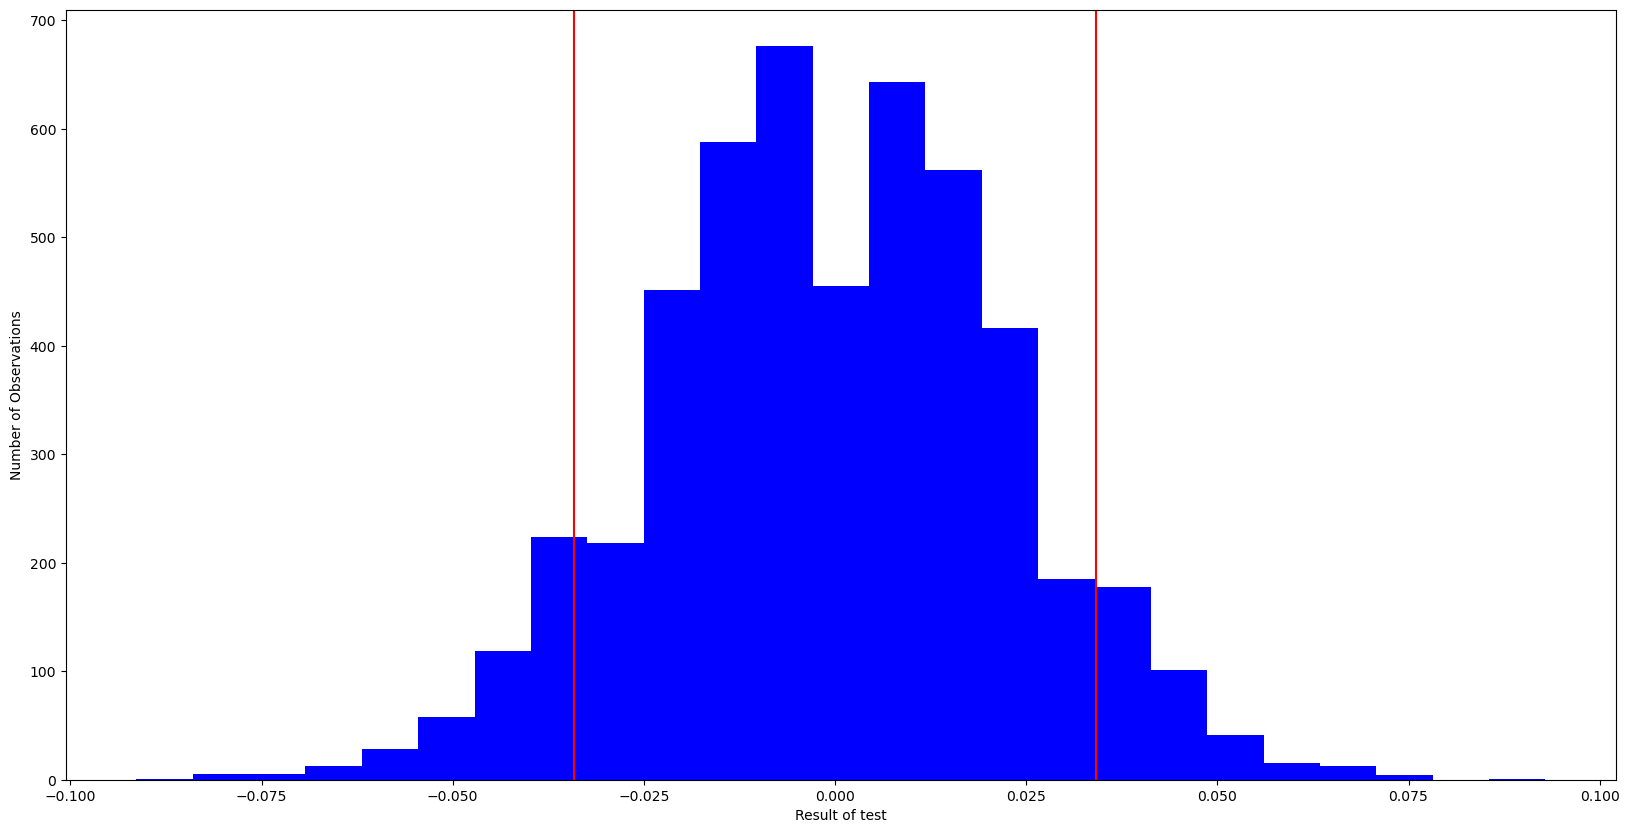

In [59]:
store = permutation_test(df, diff, shuffle = "gender", numIter = 5000, sides = 2, pBin = 25)

The p value is over 0.05 (my value is 0.1448) and therefore the null hypothesis that there is no difference in shortlisting decisions when gender is accounted for cannot be rejected. 

### Question 1.4 (5pts)
In this question we will test whether the algorithm is biased against women of ethnic minorities. We will do this by comparing the probability of being shortlisted for a application with a female minority name to anybody else. 

Add a new column entitled 'female_minority' that is 1 if the name indicates the the applicant is both female AND a member of a minority, and 0 otherwise. 

Write a function that returns the difference in the probability of getting shortlisted for female members of an ethnic minority against anybody else. Report the difference between the two groups. 

In [56]:
df["female_minority"] = np.zeros(len(df.index))
for i in range(len(df.index)):
    if df.gender[i] == "female" and df.minority[i] == 1:
        df.female_minority[i] = 1
#display(df)

def diff2(D):
    
    table = pd.crosstab(D['female_minority'], D['shortlist'], margins = True)
    mpO = table.iloc[0][1]/ table.iloc[0]["All"] 
    mpFM = table.iloc[1][1]/table.iloc[1]["All"]
    diff = (mpO - mpFM)
    return diff

print("The difference in being short listed as a minority female as opposed to anyone shortlisted within all applicants is", diff2(df))

The difference in being short listed as a minority female as opposed to anyone shortlisted within all applicants is 0.08481002825544473


/var/folders/89/nzdnlgpx6j36hmhlf7gs7k7c0000gn/T/ipykernel_1751/607542534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.female_minority[i] = 1


### Question 1.5: (7pts)
In this question you will determine whether the difference observed in Q.1.4 constitute significant discrimination against women of ethics minorities. 

You want to test the hypothesis that the algorithm is *less likely* to shortlist the candidate, if the name on the application suggests that the applicant is both female and a member of a minority.  

* Formulate the Null-hypothesis 
* Conduct a randomization test (with at least 5000 iterations) where you randomly randomly shuffle the column of the dataframe that is exchangeable under the Null hypothesis. 
* Plot a histogram of the difference in probability between male and female candidates. 
* Choose whether you are conducting a one-sided or two-sided test
* Report the p-value for testing the the hypothesis and draw a conclusion

H0: There is no difference in shortlisting decisions when the applicant is a female and minority   
HA: A minority female is less likely to make the shortlist

The p-value is 0.006


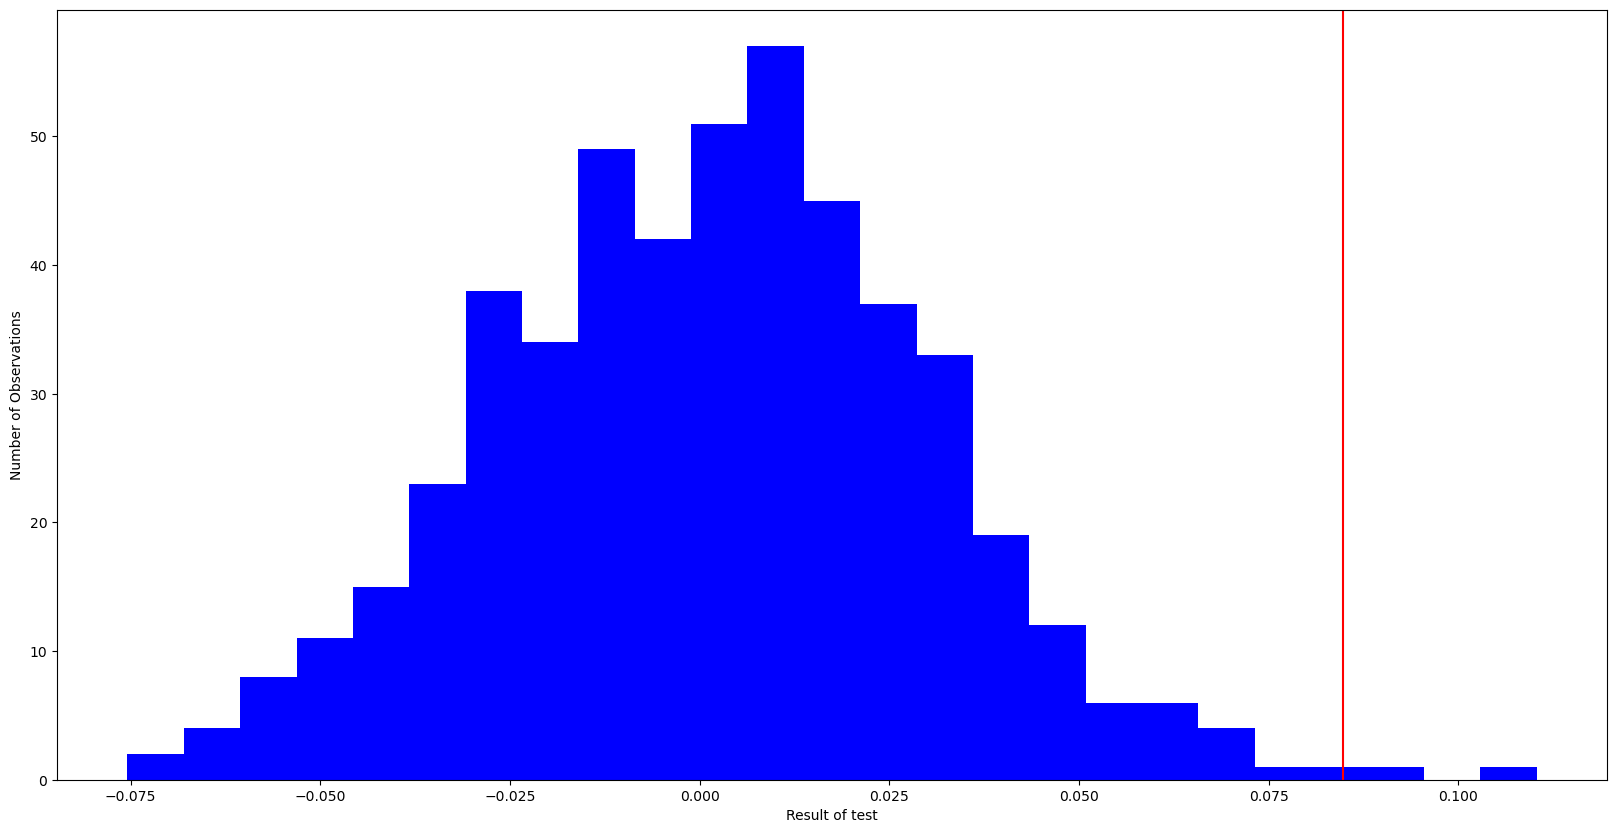

In [58]:
store = permutation_test(df, diff2, shuffle = "shortlist", numIter = 5000, sides = 1, pBin = 25)

The p-value is less 0.05 (mine was 0.006) than and therefore the null hypothesis that there is no difference in shortlisting decisions when the applicant is a female and minority can be rejected

## Task 2: (25pts)

Instead of just doing a randomization test to test your hypotheses, you decide that you also need to account for possible other differences between the applications. 
Even though you randomly assigned the name to each application, you cannot be sure that they are exactly matched between the groups. 
So you decided to build and test different models of the shortlisting decision of the algorithm. 

## Question 2.1: (4pts) 

Create dummy coded variables for gender (male / female) 
and undergraduate major (DataSci, CompSci, Stats).

You are free to choose on of the variables as comparison group - just be aware that it will influence the your interpretation of the regression coefficients later on. 

Based on your dummy variable, report the proportion of applications that have labels with having a "Data Science" Major. 

In [61]:
# Comp group male
dFemale = df['gender'] == 'female'
dFemale = np.double(dFemale)
df['dFemale']  = dFemale

# Comp group stats
dDS = df['undergrad_degree'] == 'DataSci'
dDS = np.double(dDS)
df['dDS']  = dDS

dCS = df['undergrad_degree'] == 'CompSci'
dCS = np.double(dCS)
df['dCS']  = dCS

print(sum(dDS)/len(df.index))
print("number of data sci majors / total")


0.34
number of data sci majors / total


34% of application have data science listed as their major

### Question 2.2: Build regression model (9pts)

Build a regression model to predict the shortlisting decision (1/0) of the algorithm based on the following variables:

* gender (dummy coded)
* undergrad_degree (dummy coded)
* minority
* GPA 


Written answer: From among multiple Regression, median regression, and logistic regression, choose the most appropriate regression technique and justify your choice. 

Estimate and report the parameters of your model. 

Written answer: Interpret the gender, minority, and undergraduate degree effects. Which of the groups does the algorithm have a preference for? 

In muliple regression the response variable is explained by a linear combination of response variables. In log regression you are aiming to fit probability values. I think that the most appropriate technique is multiple regression because you are looking at how different variables specifically affect the shortlisting decision. 

In [9]:
def multiRegPredict(b, df, xname):

    ## the intercept is the first element of the parameter array multiplied by 1.
    yp = np.ones(len(df.index)) * b[0]

    for i in range(len(xname)):
        xcurrent = df[xname[i]]
        yp = yp + b[i+1]*xcurrent # Add each regression value 

    return yp

def multiRegLossRSS(b, df, y, xname):
    # 1. calculate the residuals
    yp = multiRegPredict(b, df, xname)

    res = y - yp
    res2 = res ** 2
    RSS = sum(res2)
    
    
    # 1. initialize the derivative array
    deriv = np.zeros(len(b))

    ## the first element will be the derivative in respect to the intercept
    deriv[0] = -2*sum(res)
    
    # 2. build up the array using a for loop 
    for i in range(0, len(xname)):
        deriv[i+1] = -2*np.sum(df[xname[i]]*res)
    
    return RSS, deriv

def multiRegFit(df, y, xname):
    b0 = np.zeros(len(xname)+1)
    
    result = so.minimize(multiRegLossRSS, b0, args=(df, y, xname), jac=True)
    
    b = result.x
    
    TSS = sum((y - np.mean(y))**2)

    RSS, deriv = multiRegLossRSS(b,df,y,xname)
    R2 = 1 - RSS/TSS 

    return R2, b

In [10]:
R2, b  = multiRegFit(df, y = df["shortlist"], xname = ["dFemale", "dDS", "dCS", "minority", "GPA"])
print("The fit (R2) is", R2)
print("the regression coeff are", b)

The fit (R2) is 0.015592140579468339
the regression coeff are [ 0.12622031 -0.03807095  0.04160483 -0.03704301 -0.06445137  0.05930364]



The algorithm has the biggest preference for gender as it has the largest regression coeff. 

### Question 2.3: (8pts)
Use Model comparison to determine whether gender has an effect on the probability of being shortlisted, after we account for the variables (minority, undergrad_degree, and GPA). 

Compare the models using 50-fold cross-validation to determine the cross-validated prediction performance the two appropriate model.

Is there positive evidence (in the sense of Kass & Raftery, 1995) for an effect of gender on the algorithms decision, after we account for minority, undergrad_degree, and GPA.

In [83]:
# def logisticRegPredict(b,D,xname):
#     yp=np.ones(len(D.index))*b[0]       # Start out with the intercept  
#     for i in range(len(xname)):
#         yp=yp+D[xname[i]]*b[i+1]        # Add the prediction of each regressor seperately 
#     p = np.exp(yp)/(1+np.exp(yp))
#     p = p.clip(1e-12,1-(1e-12))
#     return p 
    
# def logisticRegLoss(b,D,y,xname):
#     p = logisticRegPredict(b,D,xname)
#     cost = -y*np.log(p)-(1-y)*np.log(1-p)
#     N=len(xname)
#     grad=np.zeros(N+1)
#     res = y-p
#     grad[0]=-sum(res)
#     for i in range(N):
#         grad[i+1]=-np.sum(D[xname[i]]*res)         # Add each regressor 
#     return (cost.sum(),grad)
    
# def logisticRegFit(D,y,xname,figure=0,b0=[]):
#     k=len(xname)+1
#     if (len(b0)!=k):
#         b0=np.zeros(k)
#     RES = so.minimize(logisticRegLoss,b0,args=(D,y,xname),jac=True)
#     b = RES.x
#     ll = -RES.fun # Negative function value is the log likelihood 
#     p = logisticRegPredict(b,D,xname)
#     if (k==2 & figure==1):
#         fig = plt.figure()
#         ax = fig.add_subplot(1,1,1)
#         ax.scatter(D[xname[0]],y)
#         xRange=[min(D[xname[0]]),max(D[xname[0]])]
#         xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
#         yp=b[0]+b[1]*xp
#         pp=np.exp(yp)/(1+np.exp(yp))
#         ax.plot(xp,pp,'r-')
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#     return (ll,b)


# def KfoldCVlogisticReg(D,y,xname,K=20,fitfcn=logisticRegFit,predictfcn=logisticRegPredict):
#     N = len(y) #Number of observations
#     yp= np.zeros(N)
#     ind = np.arange(N)
#     ind = np.floor(ind/N*K)
    
#     # Get overall model fit 
#     LL,b_all=fitfcn(D,y,xname,figure=0)
    
#     # Loop over the crossvalidation folds 
#     for i in range(K):
#         r,b=fitfcn(D[ind!=i],y[ind!=i],xname,b0=b_all,figure=0)
#         yp[ind==i]=predictfcn(b,D[ind==i],xname)
#     LLcv = sum(y*np.log(yp)+(1-y)*np.log(1-yp))
#     return LLcv,LL 

def multRegPredict(b,D,xname):
    """Prediction function for multipel regression 

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        xname (list): List of strings with names of explanatory variables  

    Returns:
        yp (nd.array): Predicted y - values 
    """
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value 
    return yp 

def multRegLossRSS(b,D,y,xname):
    """Loss function for OLS multiple regression 

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables  

    Returns:
        rss: Current loss
        grad: gradient of loss function in respect to parameters  
    """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname=[],figure=0,b0=[]):
    """Fits a multiple regression loss function 

    Args:
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables  
        figure (int): Plot figure? Defaults to 0.
        b0 (np.ndarray). Initial guess for the parameter vector

    Returns:
        R2: Fitted R2 value 
        b: Fitted 
    """
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

def KfoldCVmultReg(D,y,xname,K=20):

    N = len(y) #Number of observations
    yp= np.zeros(N)

    # Make an index vector with K folds
    ind = np.arange(N)
    ind = np.floor(ind/N*K)
    
    # Get overall model fit 
    R2,b_all=multRegFit(D,y,xname)

    # Loop over the crossvalidation folds 
    for i in range(K):
        r,b=multRegFit(D[ind!=i],y[ind!=i],xname,b0=b_all)
        yp[ind==i]=multRegPredict(b,D[ind==i],xname)
        
    # Calculate crossvalidated model fit 
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS
    return R2cv,R2 

In [84]:
KfoldCVmultReg(df, y = df["shortlist"], xname = ["dFemale", "dDS", "dCS", "minority", "GPA"], K=50)

# Bayes factor division
#BF10 = BF1/BF0 but logistic... 

(0.007833226524507686, 0.015592140579468117)

| Bayes Factor        | Log Bayes Factor |Evidence         |
|---------|----------|----------|
| <1    |  <0 | Negative, in favour of the other hypothesis |
| 1-3 | 0-1 | Barely worth mentioning |
| 3-20  | 1-3  | Positive              | 
| 20-150| 3-5  | Strong|
|>150| >5  | Very Strong

Based on the evidence from the bayes factor calculated I can draw the conclusion that the evidence is XXXXX, based on the table above.  

*I could not not get the right values. After obtainsing the two values you divide for the factor and using the number obtained you can use the table.*

### Question 2.4 (4pts)
Now use the same approach as in Question 2.3 to test whether being a female AND a member of minority has an influence of the algorithms decision, after we  account for the influence of GPA and undergraduate degree. 

In [86]:
KfoldCVmultReg(df, y = df["female_minority"], xname = ["dDS", "dCS", "GPA"], K=50)

(-0.00204103433071956, 0.003160248001413013)

The negative R2cv means that degree and GPA do not add predictive value. Because it is lower than 0 a simple mean may be a better predictor.

## Task 3: Regularized logistic regression (19pts)
Because there are so many potential variables that could influence the algorithm's decision, you want to implement a L2-regularized version of logistic regression. 
Having taken Data Science 2000, you decide to do it the hard (and heroic) way, and write the code yourself. That way you can be sure your really know what is going on!

### Question 3.1  (3pts)

Z-standarize the variables GPA, age, gender (dummy coded), minority (dummy coded). 

Check that the variables have after standardization (approximately) a mean of 0 and a standard deviation of 1 by reporting the mean and standard deviations of one of the variables. 

In [87]:
def zstandardize(d):
    d = (d-d.mean())/d.std()
    return d

df['zAge'] = zstandardize(df.age)
df['zGPA'] = zstandardize(df.GPA)
df['zdFemale'] = zstandardize(df.dFemale)
df["zMinority"] = zstandardize(df.minority)

print('Mean:',df.zAge.mean())
print('Std:',df.zAge.std())

Mean: 1.2034817586936698e-16
Std: 1.0000000000000024


### Question 3.2 (7pts)
Change the loss function for logistic regression (i.e. see Assignment 11 solutions) to include L2-regularization.

Regularize all regression coefficients except the intercept with a regularization coefficient of alpha = 0.1. 
Adjust the gradients accordingly.

Calculate the loss and gradients for the regularized logistic regression model, using the variables: 

* Intercept 
* age (z-standardized)
* GPA (z-standardized)
* gender (dummy coded and z-standardized)
* minority (dummy coded and z-standardized)


Report the loss and gradient for the regularized model (alpha = 0.1) and compare it to the loss for the unregularized model for the parameters 
`b= [-0.5,0.2,0.3,-0.2,-0.2]`
(these are the regression coefficients for [intercept, ageZ, GPAZ, genderZ, minorityZ])

Written answer: 
   * Why does the regularized model have a higher loss than the non-regularized model?
   * Which direction do you have to change the regression coefficient for the intercept to lower the loss? 


**L2 = RIDGE REGRESSION**

In [89]:
def ridgeLoss(b,D,y,xname,alpha=1.0):
    """Loss function for Ridge regression """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)+alpha*sum(b[1:]**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)+2*alpha*b[i+1]
    return (rss,grad)

def ridgeFit(D,y,xname,figure=0,b0=[],alpha=1.0):
    """Fits a multiple regression loss function """
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,))
    RES = so.minimize(ridgeLoss,b0,args=(D,y,xname,alpha),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multiRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

R2, b = ridgeFit(df, df["shortlist"], xname = ["zAge", "zGPA", "zMinority", "zdFemale"], alpha = 0.1)
print("The fit (R2) is", R2)
print("the regression coeff are", b)

rss, b = ridgeFit(df, df["shortlist"], xname = ["age", "GPA", "minority", "dFemale"], b0 = [-0.5,0.2,0.3,-0.2,-0.2], alpha = 0.1)
print("The fit (R2) is", R2)
print("the regression coeff are", b)

The fit (R2) is 0.03181829347242082
the regression coeff are [ 0.266       0.06493374  0.02739556 -0.032613   -0.01930407]
The fit (R2) is 0.03181829272980563
the regression coeff are [-0.51497405  0.02259164  0.05885001 -0.06520423 -0.03861667]


Written answer: 
   * Why does the regularized model have a higher loss than the non-regularized model?
   * Which direction do you have to change the regression coefficient for the intercept to lower the loss? 
   
The regularized model has a higher loss than the non-regularized model because...Well I didn't know how to get teh loss function working on it's own, so I have the R2 values. But in theory the regularized model has higher loss because of the greater penality on large coefficients?

If intercept and slope are negative, increase values to get the lowest loss (closest to 0)  
If intercept and slope are positive, decrease values to get the lowest loss (closest to 0)  
*Seeing as I could not obtained values this is the directions of which I would change the coefficients- Based on my number the intercept needs to increase in the non-regularized model*

### Question 3.3 (9pts)
Change the logisticRegFit from Assignment 10/11 to use regularization. 
Fit the the model from question Q3.2 (age, GPA, gender, minority), using L2 regularization with alpha = 0.1. 

The function should return the log-likelihood of the data given the model (*Hint: In this case this is not anymore equal to the negative loss!*) 

Compare the logliklihood and the parameters to the fit of the unregularized model.

Written answer: What can you conclude from the comparison of the log-likelihood? Can you determine which model is better?

Written answer: What is the difference between the regression coefficients of the regularized and unregularized model? How can you explain this difference?

In [ ]:
def ridgeFit(D,y,xname,figure=0,b0=[],alpha=1.0):
    """Fits a multiple regression loss function """
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,))
    RES = so.minimize(ridgeLoss,b0,args=(D,y,xname,alpha),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multiRegLossRSS(b,D,y,xname)
    
    R2 = 1-RSS/TSS # IS THIS RIGHT OR     ll = -RES.fun # Negative function value is the log likelihood 
    
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

In [90]:
R2, b = ridgeFit(df, df["shortlist"], xname = ["zAge", "zGPA", "zMinority", "zdFemale"], alpha = 0.1)
print("The fit (R2) is", R2)
print("the regression coeff are", b)

The fit (R2) is 0.03181829347242082
the regression coeff are [ 0.266       0.06493374  0.02739556 -0.032613   -0.01930407]


Written answer: What can you conclude from the comparison of the log-likelihood? Can you determine which model is better?

Written answer: What is the difference between the regression coefficients of the regularized and unregularized model? How can you explain this difference?

Log likelihood follows the bayes factor rules.  

| Bayes Factor        | Log Bayes Factor |Evidence         |
|---------|----------|----------|
| <1    |  <0 | Negative, in favour of the other hypothesis |
| 1-3 | 0-1 | Barely worth mentioning |
| 3-20  | 1-3  | Positive              | 
| 20-150| 3-5  | Strong|
|>150| >5  | Very Strong

Based on the evidence from the log bayes factor calculated I can draw the conclusion that the evidence is XXXXX, based on the table above. 

**Congrats: This is the end! You are done with the Final and Data Science 2000. This was a challenging course, and if you finished the final, you can be proud of yourself!**